In [5]:
import numpy as np        # check NumPy
import tinyarray          # check tinyarray

In [6]:
import kwant              # check Kwant core
from scipy.linalg import eigh
from scipy.constants import hbar, e as e_charge, k as k_boltzmann

In [7]:
from tqdm.notebook import tqdm

In [23]:
# ========== Corrected Code ==========
import kwant, tinyarray, numpy as np
from scipy.constants import h, e

# ========== Parameters ==========
a = 1.0           # Lattice constant
t = 1.0           # Hopping
mu = 0.0          # Chemical potential
alpha = 0.1       # Rashba SOC
Delta0 = 0.005    # SC gap
h_exchange = 0.2  # Exchange field
phi0 = h/(2*e)    # Flux quantum
B = 120.0           # Magnetic field
phase = 70.0       # Phase difference

# ========== Geometry ==========
Ls, Lf = 30, 10   # Superconductor/Ferromagnet lengths
Ly = 20           # Junction width
Lx = Ls + Lf + Ls

# ========== Matrix Definitions ==========
# Spin space matrices
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

# Particle-hole space matrices
tau_0 = tinyarray.array([[1,0],[0,1]])
tau_x = tinyarray.array([[0,1],[1,0]])
tau_y = tinyarray.array([[0,-1j],[1j,0]])  # Essential for complex pairing
tau_z = tinyarray.array([[1,0],[0,-1]])

# ========== System Construction ==========
lat = kwant.lattice.square(a,norbs=4)
sys = kwant.Builder()

# Add sites
sys[(lat(x, y) for x in range(Lx) for y in range(Ly))] = None  # All sites

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [24]:
# Set onsite Hamiltonians
for x in range(Lx):
    for y in range(Ly):
        # Determine region
        if x < Ls:
            Delta = Delta0 * np.exp(1j*phase/2)  # Left SC
            exchange = 0
        elif x < Ls + Lf:
            Delta = 0                            # Ferromagnet
            exchange = h_exchange
        else:
            Delta = Delta0 * np.exp(-1j*phase/2) # Right SC
            exchange = 0

        H_onsite = (
            (4*t - mu) * np.kron(sigma_0, tau_z) 
            + exchange * np.kron(sigma_z, tau_z)
            + np.real(Delta) * np.kron(sigma_0, tau_x)
            + np.imag(Delta) * np.kron(sigma_0, tau_y)
        )
        sys[lat(x, y)] = H_onsite

# Add hoppings (corrected boundary conditions)
# Horizontal hoppings (x -> x+1)
for x in range(Lx-1):  # Prevent overflow in x-direction
    for y in range(Ly):
        hop = -t*np.kron(sigma_0, tau_z) - 1j*alpha*np.kron(sigma_y, tau_z)
        phi = 2*np.pi * B * y * a**2 / phi0
        sys[lat(x+1, y), lat(x, y)] = hop * np.exp(1j*phi)

# Vertical hoppings (y -> y+1)
for x in range(Lx):
    for y in range(Ly-1):  # Prevent overflow in y-direction
        hop = -t*np.kron(sigma_0, tau_z) + 1j*alpha*np.kron(sigma_x, tau_z)
        sys[lat(x, y+1), lat(x, y)] = hop

# Finalize system
sys = sys.finalized()

In [15]:
def calculate_ldos(sys, energy=0.0, broadening=0.01):
    """Compute LDOS at given energy with proper site indexing"""
    ham = sys.hamiltonian_submatrix()  # Remove params unless parameterized
    energies, states = np.linalg.eigh(ham)
    num_sites = len(sys.sites)         # Use len() instead of .size
    ldos = np.zeros(num_sites)
    
    # Each site has 4 components: e↑, e↓, h↑, h↓
    for eig, vec in zip(energies, states.T):
        weight = np.exp(-(eig - energy)**2/(2*broadening**2))
        for site_idx in range(num_sites):
            # Get components for current site
            start = 4 * site_idx
            electron = vec[start:start+2]  # First two components
            hole = vec[start+2:start+4]    # Last two components
            ldos[site_idx] += weight * (np.sum(np.abs(electron)**2) 
                                      + np.sum(np.abs(hole)**2))
            
    return ldos

# Visualization with proper site positions
def plot_ldos(sys, ldos):
    sites = sys.sites
    x_pos = [site.pos[0] for site in sites]
    y_pos = [site.pos[1] for site in sites]
    
    plt.scatter(x_pos, y_pos, c=ldos, s=10, cmap='viridis')
    plt.colorbar(label='LDOS')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title(f'Local Density of States at E={energy}eV')
    plt.show()



In [25]:
# Usage
energy = 1.0  # Fermi level
ldos = calculate_ldos(sys, energy=energy)

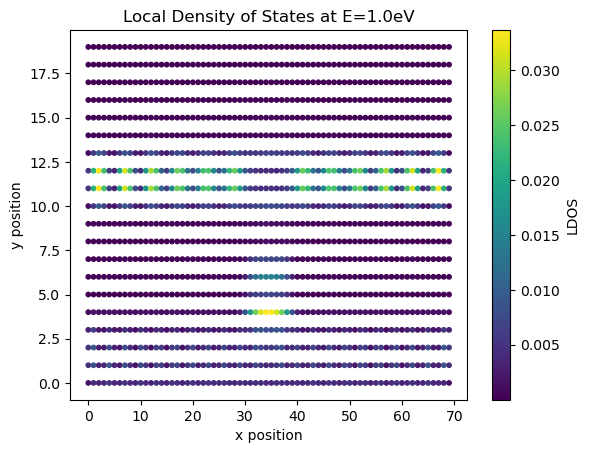

In [17]:
import matplotlib.pyplot as plt

plot_ldos(sys, ldos)

In [41]:
# Onsite Hamiltonian (4×4 matrices)
def onsite(site, phase, B):
    x, y = site.pos
    if x < Ls*a:
        Delta = 0.2 * np.exp(1j*phase/2)
    elif x >= (Ls+Lf)*a:
        Delta = 0.2 * np.exp(-1j*phase/2)
    else:
        Delta = 0.0
        
    return (
        (4*t - mu) * np.kron(sigma_0, tau_z) +        # Kinetic energy
        h_exchange * np.kron(sigma_z, tau_z) +         # Exchange field
        np.real(Delta) * np.kron(sigma_0, tau_x) +     # Real pairing
        np.imag(Delta) * np.kron(sigma_0, tau_y)       # Imaginary pairing
    )

# Geometry
def shape(pos):
    x, y = pos
    return (0 <= x < Lx*a) and (0 <= y < Ly*a)

In [43]:
# Build system with 4 orbitals per site
lat = kwant.lattice.square(a, norbs=4)  # Critical: norbs=4
sys = kwant.Builder()
sys[lat.shape(shape, (0, 0))] = onsite

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [53]:
# Finalize and compute Hamiltonian
params = dict(phase=np.pi, B=0)
ham = sys.finalized().hamiltonian_submatrix(params=params)
print(ham.shape)  # Should be (Lx*Ly*4, Lx*Ly*4)

(5600, 5600)


In [51]:
# Build system with 4 orbitals per site
lat = kwant.lattice.square(a, norbs=4)  # Critical: norbs=4
sys = kwant.Builder()
sys[lat.shape(shape, (0, 0))] = onsite

# Finalize and compute Hamiltonian
params = dict(phase=np.pi, B=0)

ham = sys.finalized()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [55]:
ham

array([[ 4.2000000e+00+0.j ,  1.2246468e-17-0.2j,  0.0000000e+00+0.j ,
        ...,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
         0.0000000e+00+0.j ],
       [ 1.2246468e-17+0.2j, -4.2000000e+00+0.j ,  0.0000000e+00+0.j ,
        ...,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
         0.0000000e+00+0.j ],
       [ 0.0000000e+00+0.j ,  0.0000000e+00+0.j ,  3.8000000e+00+0.j ,
        ...,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
         0.0000000e+00+0.j ],
       ...,
       [ 0.0000000e+00+0.j ,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
        ..., -4.2000000e+00+0.j ,  0.0000000e+00+0.j ,
         0.0000000e+00+0.j ],
       [ 0.0000000e+00+0.j ,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
        ...,  0.0000000e+00+0.j ,  3.8000000e+00+0.j ,
         1.2246468e-17+0.2j],
       [ 0.0000000e+00+0.j ,  0.0000000e+00+0.j ,  0.0000000e+00+0.j ,
        ...,  0.0000000e+00+0.j ,  1.2246468e-17-0.2j,
        -3.8000000e+00+0.j ]], shape=(5600, 5600))

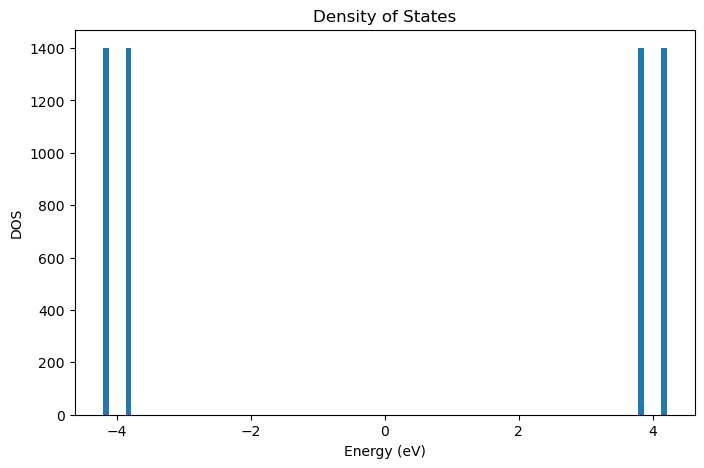

In [56]:
# Diagonalize Hamiltonian
energies = np.linspace(-Delta0*1.5, Delta0*1.5, 100)
eigvals = np.linalg.eigvalsh(ham)

# Plot spectrum
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(eigvals, bins=100)
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.title('Density of States')
plt.show()

In [57]:

print("Min eigenvalue:", eigvals.min())
print("Max eigenvalue:", eigvals.max())

Min eigenvalue: -4.2047592083257275
Max eigenvalue: 4.2047592083257275


In [47]:
B_fields = np.linspace(0, 2, 100)  # In units of Φ/Φ0
critical_currents = []

for B in B_fields:
    # Rebuild system with magnetic field
    params = dict(B=B, phase=np.pi/2)  # Phase for max current
    H = sys.hamiltonian_submatrix(params=params)
    eigvals = np.linalg.eigvalsh(H)
    
    # Find critical current at this B
    dEdphi = np.gradient(eigvals, params['phase'])
    Ic = np.max(np.abs((2*e/h)*dEdphi))
    critical_currents.append(Ic)

plt.plot(B_fields, critical_currents)
plt.xlabel('Magnetic Field (Φ/Φ₀)')
plt.ylabel('Critical Current I_c')

AttributeError: 'Builder' object has no attribute 'hamiltonian_submatrix'.
It looks like you need a finalized system; use Builder.finalized() first.

In [32]:
# Define parameter-dependent hopping (Peierls phase)
def hopping(site1, site2, B):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    phase = 2*np.pi * B * (y1 + y2)/2 * a**2 / phi0
    return hop_base * np.exp(1j*phase)

# Build system with B as a parameter
sys[lat.neighbors()] = hopping

# Compute Hamiltonians at different B values
ham_B0 = sys.finalized().hamiltonian_submatrix(params={"B": 0, "phase": 0})
ham_B1 = sys.finalized().hamiltonian_submatrix(params={"B": 1, "phase": 0})

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


TypeError: Expecting an arraylike object or a scalar.

In [58]:
# Layer structure (in lattice sites)
layers = [
    ("Nb", 25), ("Al", 2.4),  # Repeat 3 times
    ("Nb", 25), ("Al", 2.4),
    ("Nb", 25), ("Al", 2.4),
    ("Nb", 20),
    ("Cu", 2),
    ("Cr", x),  # User-defined Cr thickness
    ("Fe", 3),
    ("Cr", x),
    ("Cu", 2),
    ("Nb", 5),
    ("Au", 10)
]

# Material parameters (modify as needed)
params = {
    "Nb": {"Delta": 0.2, "h": 0.0, "alpha": 0.0},     # Superconductor
    "Al": {"Delta": 0.1, "h": 0.0, "alpha": 0.0},      # Proximity SC
    "Cu": {"Delta": 0.0, "h": 0.0, "alpha": 0.1},      # Normal metal with SOC
    "Cr": {"Delta": 0.0, "h": 0.5, "alpha": 0.2},      # Magnetic with SOC
    "Fe": {"Delta": 0.0, "h": 1.0, "alpha": 0.0},      # Ferromagnet
    "Au": {"Delta": 0.0, "h": 0.0, "alpha": 0.0}       # Normal metal
}

In [59]:
# Pauli matrices (spin and Nambu space)
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]], complex)
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(layers, params, Lx, Ly):
    lat = kwant.lattice.square(a=1, norbs=4)  # 4 orbitals per site
    sys = kwant.Builder()

    # Calculate cumulative layer positions
    x_pos = 0
    layer_boundaries = []
    for material, thickness in layers:
        layer_boundaries.append((x_pos, x_pos + thickness))
        x_pos += thickness

    # Define onsite Hamiltonian
    def onsite(site, phase, B):
        x, y = site.pos
        material = None
        for (start, end), (mat, _) in zip(layer_boundaries, layers):
            if start <= x < end:
                material = mat
                break

        p = params[material]
        Delta = p["Delta"] * np.exp(1j * phase * (-1 if "left" in material else 1))  # Adjust phase winding
        H = (
            (4 * t - mu) * np.kron(sigma_0, tau_z) +
            p["h"] * np.kron(sigma_z, tau_z) +
            np.real(Delta) * np.kron(sigma_0, tau_x) +
            np.imag(Delta) * np.kron(sigma_0, tau_y) +
            p["alpha"] * (np.kron(sigma_y, tau_z) * (-1j * (y % 2)))  # Rashba SOC in specific layers
        )
        return H

    # Define hoppings (adjust for material interfaces)
    def hopping(site1, site2, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        phase = 2 * np.pi * B * (y1 + y2) * a**2 / phi0  # Peierls phase
        return (-t * np.kron(sigma_0, tau_z) - 1j * params["alpha"] * np.kron(sigma_y, tau_z)) * np.exp(1j * phase)

    # Build 2D system
    sys[lat.shape(lambda pos: 0 <= pos[0] < Lx and 0 <= pos[1] < Ly, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping

    return sys.finalized()

In [60]:
# Initialize system
Lx_total = sum(thickness for _, thickness in layers)
Ly = 20  # Width of junction
sys = make_system(layers, params, Lx_total, Ly)

# Compute DOS at B=0 and ϕ=π
ham = sys.hamiltonian_submatrix(params={"phase": np.pi, "B": 0})
eigvals = np.linalg.eigvalsh(ham)

# Plot density of states
import matplotlib.pyplot as plt
plt.hist(eigvals, bins=100, range=(eigvals.min(), eigvals.max()))
plt.xlabel("Energy (eV)")
plt.ylabel("DOS")
plt.title("Density of States for Multilayer Junction")
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


UserCodeError: Error occurred in user-supplied value function "hopping".
See the upper part of the above backtrace for more information.